In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy


In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

LG = pklload("./database/00_LocalGroup_fix.pickle")
print(LG.keys())
print(LG[2].keys())

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])


See `03_SFR_of_sub.py`  
Output:
- `./database/03_SFR_in_sub.pickle`

In [33]:
MASSs = pklload("./database/01_mass_in_sub.pickle")
MASSs_rvir = pklload("./database/01_mass_in_sub.pickle")
SFRs = pklload("./database/03_SFR_in_sub.pickle")

In [4]:
SFRs.dtype

dtype((numpy.record, [('host', '<i4'), ('sub', '<i4'), ('dink', '?'), ('sfr', '<f8'), ('sfr_rvir', '<f8')]))

In [5]:
np.min(SFRs['sfr'])

0.0

In [6]:
BGGs = None
for key in LG.keys():
    BGG = LG[key]['BGG']
    BGGs = BGG if(BGGs is None) else np.hstack((BGGs, BGG))

subs = None
for key in LG.keys():
    sub = LG[key]['subs']
    subs = sub if(subs is None) else np.hstack((subs, sub))


mainhalos = subs['id'][ isin(subs['id'], BGGs['halo_id']) ]
for key in LG.keys():
    hids = LG[key]['real']['hid']
    ind = isin(hids, mainhalos)
    if(True in ind):
        print(key,LG[key]['BGG']['halo_id'], LG[key]['real'][ind])

In [7]:
LG[4]['neighbor']

array([(19,  4.50112546), (68,  8.67065105), (91, 16.77077923)],
      dtype=[('id', '<i4'), ('mratio', '<f8')])

In [9]:
LG[92]['neighbor']

array([], dtype=[('id', '<i4'), ('mratio', '<f8')])

In [15]:
ssfrcut = 1 / 6 / (snap.age*1e9)

1.4338118691117342e-11

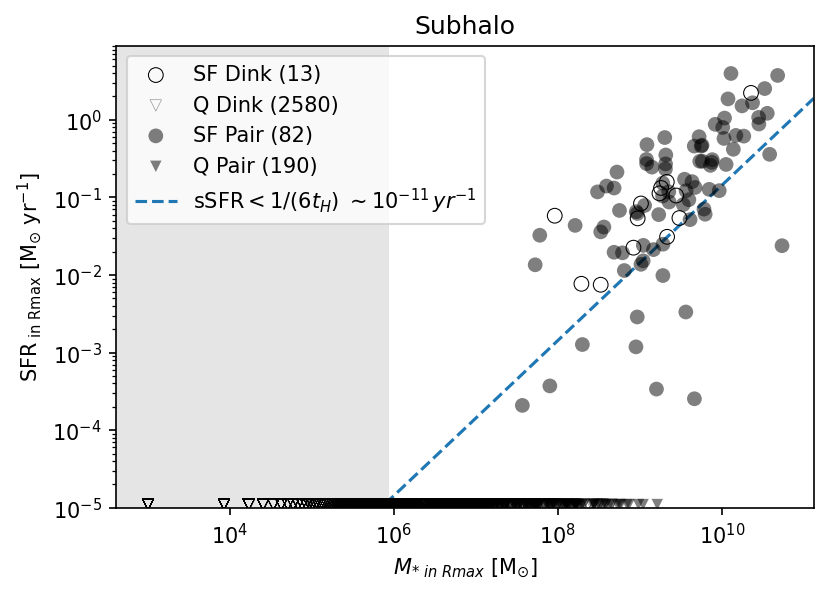

In [37]:
fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=150)

qind = SFRs['sfr']==0
dind = MASSs['dink']
# dink
ax.scatter(MASSs[~qind & dind]['mstar'], SFRs[~qind & dind]['sfr'], marker='o', ec='k',fc='none', s=50, lw=0.5, label=f'SF Dink ({np.sum(~qind & dind)})')
ax.scatter(MASSs[qind & dind]['mstar'], np.full(np.sum(qind & dind),1.1e-5), marker='v',ec='k',fc='none', s=30, lw=0.25, alpha=0.5, label=f'Q Dink ({np.sum(qind & dind)})')
# pair
ax.scatter(MASSs[~qind & ~dind]['mstar'], SFRs[~qind & ~dind]['sfr'], marker='o', fc='k',ec='none', s=50, lw=0.5, alpha=0.5, label=f'SF Pair ({np.sum(~qind & ~dind)})')
ax.scatter(MASSs[qind & ~dind]['mstar'], np.full(np.sum(qind & ~dind),1.1e-5), marker='v',ec='none',fc='k', s=30, lw=0.5, alpha=0.5, label=f'Q Pair ({np.sum(qind & ~dind)})')
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()
ax.set_xlim(xlim)
ax.set_ylim(1e-5,9e0)
ax.plot([xlim[0], xlim[1]], [xlim[0]*ssfrcut, xlim[1]*ssfrcut], ls='--', zorder=-1, label=r"sSFR$<1/(6t_H)$ $\sim10^{-11}\,yr^{-1}$")

ax.fill_betweenx([1e-5, 9e0], xlim[0], np.min(gals['m']), ec='none',fc='grey', alpha=0.2, zorder=-2)
ax.set_xlabel(r'$M_{*\ in\ Rmax}$ [M$_{\odot}$]')
ax.set_ylabel(r'$\rm{SFR}_{\rm\ in\ Rmax}$ [M$_{\odot}$ yr$^{-1}$]')
ax.set_title('Subhalo')
ax.legend()


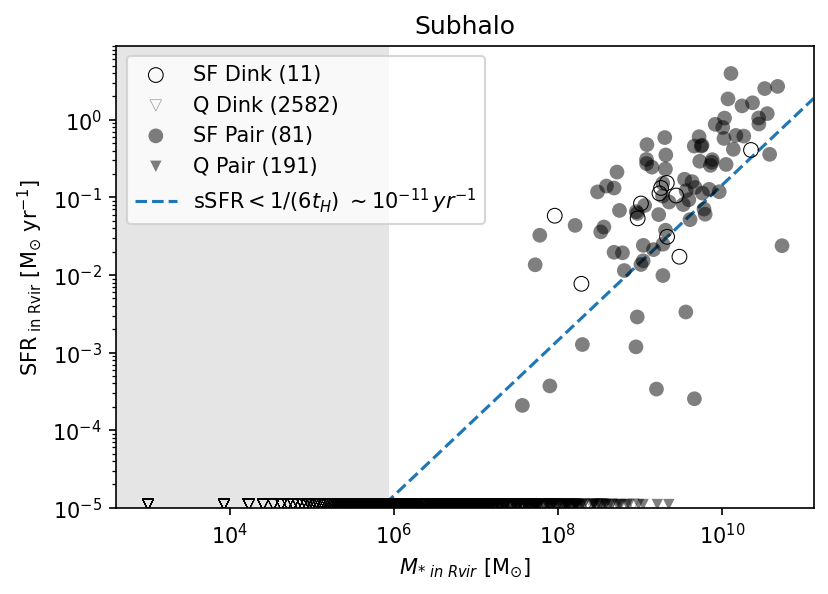

In [36]:
fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=150)

qind = SFRs['sfr_rvir']==0
dind = MASSs_rvir['dink']
# dink
ax.scatter(MASSs_rvir[~qind & dind]['mstar'], SFRs[~qind & dind]['sfr_rvir'], marker='o', ec='k',fc='none', s=50, lw=0.5, label=f'SF Dink ({np.sum(~qind & dind)})')
ax.scatter(MASSs_rvir[qind & dind]['mstar'], np.full(np.sum(qind & dind),1.1e-5), marker='v',ec='k',fc='none', s=30, lw=0.25, alpha=0.5, label=f'Q Dink ({np.sum(qind & dind)})')
# pair
ax.scatter(MASSs_rvir[~qind & ~dind]['mstar'], SFRs[~qind & ~dind]['sfr_rvir'], marker='o', fc='k',ec='none', s=50, lw=0.5, alpha=0.5, label=f'SF Pair ({np.sum(~qind & ~dind)})')
ax.scatter(MASSs_rvir[qind & ~dind]['mstar'], np.full(np.sum(qind & ~dind),1.1e-5), marker='v',ec='none',fc='k', s=30, lw=0.5, alpha=0.5, label=f'Q Pair ({np.sum(qind & ~dind)})')
ax.set_yscale('log')
ax.set_xscale('log')
xlim = ax.get_xlim()
ax.set_xlim(xlim)
ax.set_ylim(1e-5,9e0)
ax.plot([xlim[0], xlim[1]], [xlim[0]*ssfrcut, xlim[1]*ssfrcut], ls='--', zorder=-1, label=r"sSFR$<1/(6t_H)$ $\sim10^{-11}\,yr^{-1}$")

ax.fill_betweenx([1e-5, 9e0], xlim[0], np.min(gals['m']), ec='none',fc='grey', alpha=0.2, zorder=-2)
ax.set_xlabel(r'$M_{*\ in\ Rvir}$ [M$_{\odot}$]')
ax.set_ylabel(r'$\rm{SFR}_{\rm\ in\ Rvir}$ [M$_{\odot}$ yr$^{-1}$]')
ax.set_title('Subhalo')
ax.legend()
